In [1]:
from keras.models import Sequential, Model
from keras.layers import Flatten, Dense, Dropout, Reshape, Permute, Activation, BatchNormalization, \
    Input
from keras.engine.topology import merge
from keras.layers.convolutional import Convolution2D, MaxPooling2D, ZeroPadding2D
from keras.optimizers import SGD
from keras.callbacks import ModelCheckpoint, Callback
import numpy as np
from keras.wrappers.scikit_learn import KerasRegressor
from keras.applications.resnet50 import ResNet50
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from image_util import crop_center
import matplotlib.pyplot as plt
%matplotlib inline

Using TensorFlow backend.


In [2]:
# validation keras fix 
# ref: http://stackoverflow.com/questions/41796618/python-keras-cross-val-score-error/41841066#41841066
from keras.wrappers.scikit_learn import BaseWrapper
import copy

def custom_get_params(self, **params):
    res = copy.deepcopy(self.sk_params)
    res.update({'build_fn': self.build_fn})
    return res

BaseWrapper.get_params = custom_get_params


In [12]:
# load data
Xtrain = np.load('./data/dataset256/Xtrain.npy')
Xtest = np.load('./data/dataset256/Xtest.npy')
Ytrain = np.load('./data/dataset256/Ytrain.npy')
Ytest = np.load('./data/dataset256/Ytest.npy')

In [4]:
# netowrk settings
batch_size = 128
nb_epoch = 2

In [9]:
def addResidualBlock(inp, size=(3,3), subsample=(4,4), filters_conv_rate=2, name=None):
    conv_filters = int(inp.get_shape()[-1])*filters_conv_rate
    inp = BatchNormalization()(inp)
    first = Convolution2D(conv_filters, size[0], size[1], border_mode='same', subsample=subsample, activation='relu')(inp)
    
    second = BatchNormalization()(first)
    second = Convolution2D(conv_filters, 3,3, border_mode='same', activation='relu')(second)
    
    second = BatchNormalization()(second)
    second = Convolution2D(conv_filters, 3,3, border_mode='same', activation='relu')(second)
    
    return merge([first, second], mode='sum', name=name)

In [10]:
def MyResNet():
    inp = Input(shape=(256, 256,3))
    out = Convolution2D(16, 3,3, border_mode='same', activation='relu', subsample=(4,4))(inp)
    for i in range(3):
        out = addResidualBlock(out)
        out = BatchNormalization()(out)
        out = Activation('relu')(out)
    
    out = BatchNormalization()(out)
    out = Flatten()(out)
    out = Dense(128, activation='relu', name='fcc')(out)
    out = Dense(1, name='out')(out)
    
    model = Model(input=inp, output=out)

    model.compile(loss='mean_squared_error',
                  optimizer='adam')
    return model


In [11]:
model = MyResNet()
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_2 (InputLayer)             (None, 256, 256, 3)   0                                            
____________________________________________________________________________________________________
convolution2d_11 (Convolution2D) (None, 64, 64, 16)    448         input_2[0][0]                    
____________________________________________________________________________________________________
batchnormalization_14 (BatchNorm (None, 64, 64, 16)    64          convolution2d_11[0][0]           
____________________________________________________________________________________________________
convolution2d_12 (Convolution2D) (None, 16, 16, 32)    4640        batchnormalization_14[0][0]      
___________________________________________________________________________________________

In [17]:
model.set_weights('./training-checkpoint/checkpoint-99-0.00.hdf5')

ValueError: Shapes must be equal rank, but are 4 and 0 for 'Assign_151' (op: 'Assign') with input shapes: [3,3,3,16], [].

In [14]:
# batch logger 
# ref: https://github.com/fchollet/keras/issues/2850#issuecomment-222542429
class NBatchLogger(Callback):
    def __init__(self,display=100):
        '''
        display: Number of batches to wait before outputting loss
        '''
        self.seen = 0
        self.display = display

    def on_batch_end(self,batch,logs={}):
        self.seen += logs.get('size', 0)
        if self.seen % self.display == 0:
            print('\n{0}/{1} - Batch Loss: {2}'.format(self.seen,self.params['nb_sample'],
                                                self.params['metrics'][0]))

In [15]:
#train just 1000 samples, 3 epochs
# if False:
checkpoint = ModelCheckpoint(filepath='./training-checkpoint/checkpoint-{epoch:02d}-{val_loss:.2f}.hdf5')
# out_batch = NBatchLogger(display=1)
history = model.fit(x=Xtrain, y=Ytrain, 
          nb_epoch=nb_epoch, batch_size=batch_size,validation_split=0.1, verbose=1, callbacks=[checkpoint]) 

Train on 13864 samples, validate on 1541 samples
Epoch 1/2
13864/13864 [==============================] - 166s - loss: 0.1335 - val_loss: 0.0731
Epoch 2/2
13864/13864 [==============================] - 159s - loss: 0.0359 - val_loss: 0.0470


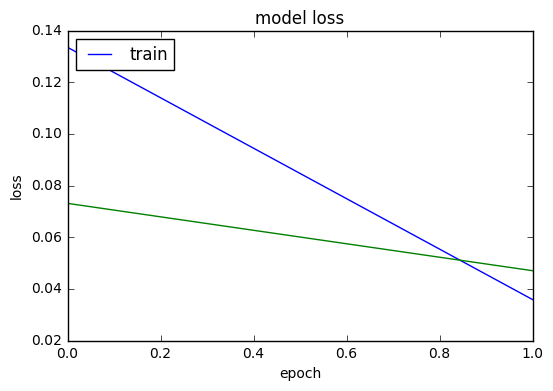

In [16]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train'], loc='upper left')
plt.show()

In [ ]:
model.evaluate(x=Xtest, y=Ytest,batch_size=batch_size)

In [ ]:
# regression 
# rev: http://machinelearningmastery.com/regression-tutorial-keras-deep-learning-library-python/

In [ ]:
# fix random seed for reproducibility
seed = 7
np.random.seed(seed)
# evaluate model with standardized dataset
estimator = KerasRegressor(build_fn=MyNet, nb_epoch=nb_epoch, batch_size=batch_size, verbose=1)

In [ ]:
kfold = KFold(n_splits=10, random_state=seed)
results = cross_val_score(estimator, Xtrain[:1000], Ytrain[:1000], cv=kfold)
print("Results: %.2f (%.2f) MSE" % (results.mean(), results.std()))